In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Download the Dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url,root='.')

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['horse', 'dog', 'frog', 'truck', 'ship', 'cat', 'deer', 'bird', 'airplane', 'automobile']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape ```(3, 32, 32)```.

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

The list of classes is stored in the ```.classes``` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [ ]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


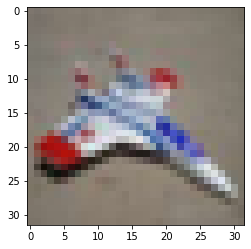

In [ ]:
import matplotlib.pyplot as plt
for img in dataset[1]:
    plt.imshow(img.permute((1,2,0)))
    break

In [ ]:
len(dataset)

50000

### Training and Validation Datasets

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size,val_size])
len(train_ds), len(val_ds)

(45000, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
#pin_memory (bool, optional) – If True, the data loader will copy Tensors into CUDA pinned memory before returning them.
#num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

## Defining the Model (Convolutional Neural Network)

The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

![conv2d](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [ ]:
def apply_kernel(image,kernel):
    ri, ci = image.shape # image dimensions
    rk, ck = kernel.shape # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1 # output dimensions
    output = torch.zeros([ro,co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

In [ ]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image,sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise.

There are certain advantages offered by convolutional layers when working with image data:

* Fewer parameters: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer.

* Sparsity of connections: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.

* Parameter sharing and spatial invariance: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layers to progressively decrease the height & width of the output tensors from each convolutional layer.

![max-pooling](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

The Conv2d layer transforms a 3-channel image to a 16-channel feature map, and the MaxPool2d layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

![cnn](https://i.imgur.com/KKtPOKE.png)

In [ ]:
def accuracy(outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
# class Cifar10CnnModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.network = nn.Sequential(
#         nn.Conv2d(3,32,kernel_size=3,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),# output: 64 x 16 x 16-> using h1=((ho - F +2P)/s) + 1)
        
#         nn.Conv2d(64,128,kernel_size=3, stride=1,padding=1),
#         nn.ReLU(),
#         nn.Conv2d(128,128,kernel_size=3, stride=1,padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2), # output: 128 x 8 x 8-> using h1=((ho - F +2P)/s) + 1)
        
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2),# output: 256 x 4 x 4 -> using h1=((ho - F +2P)/s) + 1)

#         nn.Flatten(),
#         nn.Linear(256*4*4,1024),# using h1=((ho - F +2P)/s) + 1)
#         nn.ReLU(),
#         nn.Linear(1024,512),
#         nn.ReLU(),
#         nn.Linear(512,10))
    
#     def forward(self,xb):
#         return self.network(xb)
    
#     def training_step(self,batch):
#         images,labels = batch
#         out = self(images)
#         loss = F.cross_entropy(out,labels)
#         return loss
    
#     def validation_step(self,batch):
#         images,labels = batch
#         out = self(images)
#         loss = F.cross_entropy(out,labels)
#         acc = accuracy(out,labels)
#         return {'val_loss':loss,'val_acc':acc}
    
#     def validation_epoch_end(self,outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()
#         batch_acc = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_acc).mean()
#         return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self,epoch,result):
#         print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}] val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()

In [ ]:
model.parameters

<bound method Module.parameters of Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data,device):
    if isinstance(data, (list,tuple)): #The isinstance() function returns True if the specified object is of the specified type, otherwise False.
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs,lr,model,train_loder,val_loader,opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        for batch in train_loder:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()#used to update the parameters
            optimizer.zero_grad()#Clears the gradients of  optimizer
        result = evaluate(model,val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model,val_dl)

{'val_acc': 0.103515625, 'val_loss': 2.3031060695648193}

In [ ]:
history = fit(10,0.001,model,train_dl,val_dl)

Epoch [0] val_loss: 1.4683, val_acc: 0.4592
Epoch [1] val_loss: 1.2199, val_acc: 0.5576
Epoch [2] val_loss: 0.9735, val_acc: 0.6529
Epoch [3] val_loss: 0.8919, val_acc: 0.6844
Epoch [4] val_loss: 0.7898, val_acc: 0.7223
Epoch [5] val_loss: 0.7755, val_acc: 0.7377
Epoch [6] val_loss: 0.7543, val_acc: 0.7516
Epoch [7] val_loss: 0.7657, val_acc: 0.7547
Epoch [8] val_loss: 0.8236, val_acc: 0.7494
Epoch [9] val_loss: 0.9055, val_acc: 0.7578


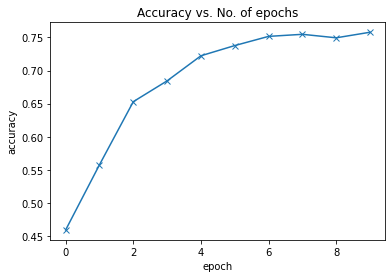

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

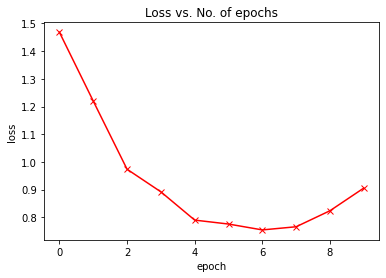

In [ ]:
val_losses = [x['val_loss'] for x in history]
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
def predict_img(img,model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,preds = torch.max(yb,dim=1)
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


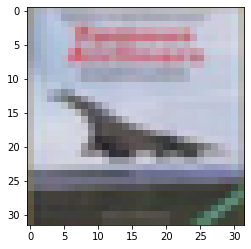

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_img(img, model))

Label: automobile , Predicted: automobile


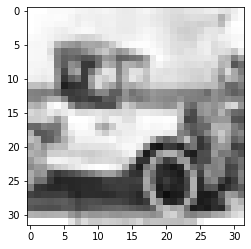

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_img(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7540038824081421, 'val_loss': 0.9058127403259277}